In [1]:
#здесь можно задать вопрос result gpt, или другим способом попросить продолжить текст. В тексте могут быть вставки графики
#Не основной режим, не ждите много
import sys
import os
import importlib

import gym
import pylab
import random
import numpy as np
from collections import deque
from pathlib import Path


import time
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import pandas as pd
import pickle
import copy
import vizdoom
from vizdoom import *
import cv2
from os.path import exists
import codecs

import torch
from transformers import GPT2Tokenizer
from transformers import AutoTokenizer, AutoModelForCausalLM


import result_gpt_res

root = './'

E:\ProgramData\Anaconda3\envs\tf\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
E:\ProgramData\Anaconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
E:\ProgramData\Anaconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas.JPIJNSWNNAN3CE6LLI5FWSPHUT2VXMTH.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
device = torch.device('cuda:0')

In [3]:
#VQ-GAN 1024 
Model = "f16_1024" #param ["f16_1024", "f16_16384", "f16_16384_hf"]
import cv2
import torch
import yaml
import torch
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from omegaconf import OmegaConf
from taming.models.vqgan import VQModel

def load_config(config_path, display=False):
  config = OmegaConf.load(config_path)
  if display:
    print(yaml.dump(OmegaConf.to_container(config)))
  return config

def load_vqgan(config, ckpt_path=None):
  model = VQModel(**config.model.params)
  if ckpt_path is not None:
    sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
    missing, unexpected = model.load_state_dict(sd, strict=False)
  return model.eval()

def preprocess_vqgan(x, roll=True):
  x = 2.*x - 1.
  if roll:
    x = np.rollaxis(x,3,1)
  x = torch.Tensor(x)
  return x

def preprocess(x, permt=True):
  if permt:
    x = x.permute(0,2,3,1).numpy()
  x = np.clip(x, -1., 1.)
  x = (x + 1.)/2.
  return x

def custom_to_pil(x):
  x = np.clip(x, -1., 1.)
  x = (x + 1.)/2.
  x = (255*x).astype(np.uint8)
  x = Image.fromarray(x)
  if not x.mode == "RGB":
    x = x.convert("RGB")
  return x

vq_conf = load_config(f"../gpt/chatgpt/chk_points/vqgan_imagenet_{Model}.yaml", display=False)
vq_model = load_vqgan(vq_conf, ckpt_path=f"../gpt/chatgpt/chk_points/vqgan_imagenet_{Model}.ckpt").to(device)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips\vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [4]:
model_name = "gpt2_finetuned_3"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [5]:
#Здесь добавляем токены ревордов
reward_to_substr = {}
rmax = 25
rmin = -25
step = 0.1
for r in np.arange(rmin, rmax, step):
    r = np.round(r, 2)
    str_r = f'<r{r}>'
    reward_to_substr[r] = str_r
substr_to_reward = {v: k for k, v in reward_to_substr.items()}
print('substr_to_reward', substr_to_reward)
print('reward_to_substr', reward_to_substr)
#сюда надо фигануть весь словарь картинок
video_tokens_cnt = 1024
video_tokens = []
for i in range(video_tokens_cnt):
    video_tokens.append(f'<{i}>')
    
#и токены ревордов тоже добавить
    
special_tokens_dict = {'additional_special_tokens': video_tokens + ['<IN>','<OUT>','<END>','|PAD|'] + list(reward_to_substr.values())}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
#print(tokenizer.all_special_tokens)
tokenizer.pad_token = '|PAD|'
r_max_token = tokenizer.encode(list(reward_to_substr.values())[-1])[0]
r_min_token = tokenizer.encode(list(reward_to_substr.values())[0])[0]
out_token = tokenizer.encode('<OUT>')[0]

substr_to_reward {'<r-25.0>': -25.0, '<r-24.9>': -24.9, '<r-24.8>': -24.8, '<r-24.7>': -24.7, '<r-24.6>': -24.6, '<r-24.5>': -24.5, '<r-24.4>': -24.4, '<r-24.3>': -24.3, '<r-24.2>': -24.2, '<r-24.1>': -24.1, '<r-24.0>': -24.0, '<r-23.9>': -23.9, '<r-23.8>': -23.8, '<r-23.7>': -23.7, '<r-23.6>': -23.6, '<r-23.5>': -23.5, '<r-23.4>': -23.4, '<r-23.3>': -23.3, '<r-23.2>': -23.2, '<r-23.1>': -23.1, '<r-23.0>': -23.0, '<r-22.9>': -22.9, '<r-22.8>': -22.8, '<r-22.7>': -22.7, '<r-22.6>': -22.6, '<r-22.5>': -22.5, '<r-22.4>': -22.4, '<r-22.3>': -22.3, '<r-22.2>': -22.2, '<r-22.1>': -22.1, '<r-22.0>': -22.0, '<r-21.9>': -21.9, '<r-21.8>': -21.8, '<r-21.7>': -21.7, '<r-21.6>': -21.6, '<r-21.5>': -21.5, '<r-21.4>': -21.4, '<r-21.3>': -21.3, '<r-21.2>': -21.2, '<r-21.1>': -21.1, '<r-21.0>': -21.0, '<r-20.9>': -20.9, '<r-20.8>': -20.8, '<r-20.7>': -20.7, '<r-20.6>': -20.6, '<r-20.5>': -20.5, '<r-20.4>': -20.4, '<r-20.3>': -20.3, '<r-20.2>': -20.2, '<r-20.1>': -20.1, '<r-20.0>': -20.0, '<r-19.9>': -

In [6]:
#r_mapping {1231:0.1, 1547:1.2} и так далее.
#маппинг с номеров токенов на реворды
r_mapping = {}
for substr in list(reward_to_substr.values()):
    r_token = tokenizer.encode(substr)[0]
    r_mapping[r_token] = substr_to_reward[substr]
print(r_mapping)

{51685: -25.0, 51686: -24.9, 51687: -24.8, 51688: -24.7, 51689: -24.6, 51690: -24.5, 51691: -24.4, 51692: -24.3, 51693: -24.2, 51694: -24.1, 51695: -24.0, 51696: -23.9, 51697: -23.8, 51698: -23.7, 51699: -23.6, 51700: -23.5, 51701: -23.4, 51702: -23.3, 51703: -23.2, 51704: -23.1, 51705: -23.0, 51706: -22.9, 51707: -22.8, 51708: -22.7, 51709: -22.6, 51710: -22.5, 51711: -22.4, 51712: -22.3, 51713: -22.2, 51714: -22.1, 51715: -22.0, 51716: -21.9, 51717: -21.8, 51718: -21.7, 51719: -21.6, 51720: -21.5, 51721: -21.4, 51722: -21.3, 51723: -21.2, 51724: -21.1, 51725: -21.0, 51726: -20.9, 51727: -20.8, 51728: -20.7, 51729: -20.6, 51730: -20.5, 51731: -20.4, 51732: -20.3, 51733: -20.2, 51734: -20.1, 51285: -20.0, 51286: -19.9, 51287: -19.8, 51288: -19.7, 51289: -19.6, 51290: -19.5, 51291: -19.4, 51292: -19.3, 51293: -19.2, 51294: -19.1, 51295: -19.0, 51296: -18.9, 51297: -18.8, 51298: -18.7, 51299: -18.6, 51300: -18.5, 51301: -18.4, 51302: -18.3, 51303: -18.2, 51304: -18.1, 51305: -18.0, 51306

In [49]:
print('mem', result_gpt_res.getmem())
model = result_gpt_res.AutoModelForCausalLMWithValueHeadCL.from_pretrained(model_name)
model.to(device)
#r_mapping {1231:0.1, 1547:1.2} и так далее.
#маппинг с номеров токенов на реворды
model.r_mapping = r_mapping
#токен <OUT>, с него начинается прогноз
model.out_token = out_token
#специальные токены { vertical-output: true }
T_OUT = tokenizer.encode('<OUT>')[0]
T_END = tokenizer.encode('<END>')[0]
T_PAD = tokenizer.encode('|PAD|')[0]
T_124 = tokenizer.encode('<124>')[0]
T_0 = tokenizer.encode('<0>')[0]
T_1023 = tokenizer.encode('<1023>')[0]

model._modules['pretrained_model'].resize_token_embeddings(len(tokenizer))

mem 0.00034427642822265625


Some weights of the model checkpoint at gpt2_finetuned_3 were not used when initializing GPT2LMHeadModel: ['v_head.0.bias', 'v_head.2.weight', 'v_head.4.weight', 'v_head.0.weight', 'v_head.2.bias', 'v_head.4.bias']
- This IS expected if you are initializing GPT2LMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2LMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Embedding(51785, 1024)

In [78]:
imsize = [16*9, 16*9]
def answer(text, images_storage=None):
    #text = '\n' + text
    if not (images_storage is None):
        p = Path(images_storage)
        i = 0
        img_name_short = text.split('<<')[1]
        img_name_short = img_name_short.split('>>')[0]
        img_name = images_storage + img_name_short

        #скачать и декодировать картинку
        img_loaded = cv2.resize(cv2.imread(str(img_name)), imsize)
        img_orig = np.array(img_loaded, dtype=np.float32)/255.
        b,g,r = img_orig[:,:,0], img_orig[:,:,1], img_orig[:,:,2]
        img_orig = np.dstack([r, g, b])
        plt.imshow(img_orig)
        plt.show()
        img = preprocess_vqgan(np.stack(1*[img_orig]), True)       

        z, _, [_, _, ind] = vq_model.encode(img.to('cuda'))
        ind.squeeze_()
        b,c,h,w = z.shape
        #nz = vq_model.quantize.get_codebook_entry(ind, (b,h,w,c))
        #print('nz', nz)
        token_string = '<' + '><'.join( [str(el) for el in list(ind.detach().cpu().numpy())] ) + '>'
        nz = vq_model.quantize.get_codebook_entry(ind, (b,h,w,c))
        
        rec = vq_model.decode(nz).detach().cpu()
        #plt.imshow(preprocess(rec)[0])
        #plt.plot()

        text = text.replace(f'<<{img_name_short}>>', token_string)

    
    
    inpt = tokenizer.encode(text, return_tensors="pt")
    inpt= inpt.cuda()
    print('QUESTION', text)

    #out = model.generate(inpt,  max_length=len(inpt[0])+300, do_sample=True, top_k=5, top_p=0.95, temperature=1, eos_token_id=T_END, pad_token_id=T_PAD)
    out = model.generate(inpt,  max_length=len(inpt[0])+300, do_sample=False, top_k=1, top_p=0.95, temperature=0.0001, eos_token_id=T_END, pad_token_id=T_PAD)

    out_tokens = torch.where(out[0]==T_OUT)
    
    
    if len(out_tokens[0]) == 0:
        whr = 0
    else:
        whr = out_tokens[0][-1]
    #print(out)
    last_repl = out[0][whr+1:-1]
    
    repl = tokenizer.decode(last_repl)

    print("ANSWER", repl)
    
    #нарисовать картинку
    idx = (last_repl >= T_0) & (last_repl <= T_1023)
    image_tokens = last_repl[idx]
    if len(image_tokens) > 0:
        image_tokens -= T_0
        image_tokens = image_tokens[:]
        b,c,h,w = 1, 256, 9, 9
        nz = vq_model.quantize.get_codebook_entry(image_tokens, (b,h,w,c))
        rec = vq_model.decode(nz).detach().cpu()
        plt.imshow(preprocess(rec)[0])
        plt.plot()

In [27]:
text = 'How old are you, comrade?'
text = f"<IN>{text}<OUT>"
answer(text)

QUESTION <IN>How old are you, comrade?<OUT>
ANSWER ?	I am not sure. I am not sure if he is a good person.	I am not sure. I am not sure. I am not sure if he is a good person.	I am sure he is a good player. He is a great player.	I am sure he is. He is a great player. He is a great player.	I am sure he is. He is a great player. He is a great player.	I agree. He is a great player. He is a great player.	I agree. He is a great player. He is a great player. He is a great player.	I agree. He is a great player. He is a great player.	I agree. He is a great player. He is a great player. He is a great player.	I agree. He is a great player. He is a great player.	I agree. He is a great player. He is a great player.	I agree. He is a great player. He is a great player.	I agree. He is a great player. He is a great player.	I agree. He is a great player.	


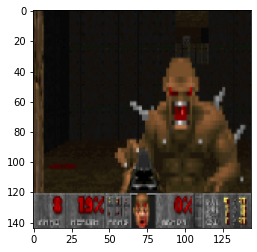

QUESTION <IN>How old are you, comrade? <325><29><639><110><714><813><503><937><534><993><597><548><110><870><590><168><761><564><202><29><688><812><330><184><308><813><556><325><189><433><946><343><477><494><632><523><72><299><245><63><260><737><464><611><725><325><748><63><40><979><638><884><150><772><868><47><811><806><925><508><83><432><188><192><945><438><32><312><608><576><215><608><109><254><700><787><258><932><92><370><7><OUT>
ANSWER  imp right-ahead,imp right-ahead,imp right-ahead,imp right-ahead,imp right-<r1.1>


In [76]:
text = 'How old are you, comrade? <<autofrcend_2023-10-29_17_17_27_137681.png>>'
text = f"<IN>{text}<OUT>"
answer(text, './data/imgs/')

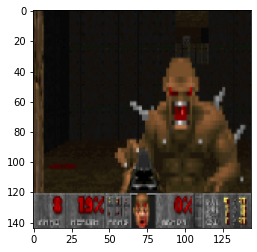

QUESTION <IN><325><29><639><110><714><813><503><937><534><993><597><548><110><870><590><168><761><564><202><29><688><812><330><184><308><813><556><325><189><433><946><343><477><494><632><523><72><299><245><63><260><737><464><611><725><325><748><63><40><979><638><884><150><772><868><47><811><806><925><508><83><432><188><192><945><438><32><312><608><576><215><608><109><254><700><787><258><932><92><370><7> plan: strafe left, forecast img:<OUT>
ANSWER  <813><29><156><813><813><813><471><698><508><813><189><913><913><813><706><590><597><172><813><597><187><918><909><66><96><937><688><556><189><556><910><250><414><985><862><688><363><54><583><748><330><681><597><572><639><717><552><564><330><256><887><941><685><688><432><243><811><258><334><556><263><226><63><988><444><438><32><761><608><576><624><140><662><254><966><354><258><816><92><370><7>


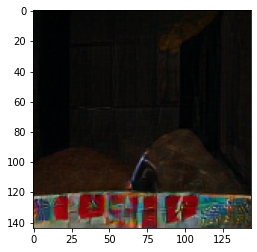

In [82]:
text = '<<autofrcend_2023-10-29_17_17_27_137681.png>> plan: strafe left, forecast img:'
text = f"<IN>{text}<OUT>"
answer(text, './data/imgs/')